In [309]:
# Imports and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt, welch, find_peaks
from scipy.integrate import trapezoid
from scipy.stats import skew, kurtosis

fs = 250 
train = np.load("hillary-trial_1.npy", allow_pickle=True)
validation = np.load("hillary-trial_2.npy", allow_pickle=True)
test = np.load("hillary-trial_3.npy", allow_pickle=True)
train_df = pd.DataFrame(train)
validation_df = pd.DataFrame(validation)
test_df = pd.DataFrame(test)

print(f"Data Shape: {train_df.shape}")
print(f"Data Shape: {validation_df.shape}")
print(f"Data Shape: {test_df.shape}")

Data Shape: (38403, 12)
Data Shape: (34013, 12)
Data Shape: (33880, 12)


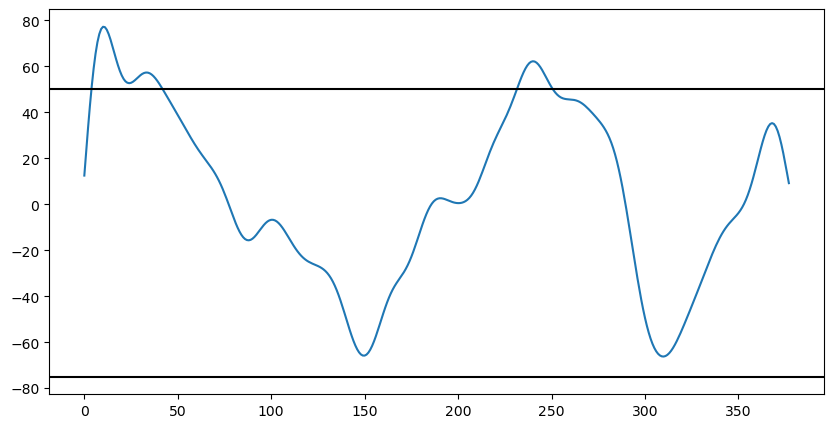

In [348]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.load("blink_graphs/img466.npy", allow_pickle=True))
ax.axhline(50, color='black')
ax.axhline(-75, color='black')

In [102]:
labels = np.load('hillary-trials.npy', allow_pickle=True)
train_labels = labels[0]
validation_labels = labels[1]
test_labels = labels[2]

In [38]:
# Labeling columns

# onset and offset of artifacts
def onset_offset_artifacts(df):
    df['onset'] = (df[9].shift(1) < 30) & (df[9] >= 30) # First onset is jaw clench and offset is jawclench
    df['offset'] = (df[9].shift(-1) < 30)& (df[9] >= 30) # Anastasyas code
    return df

def data(df):

    num_channels = 11  
    column_names = [f"EEG_{i}" for i in range(1, 9)]  # 8 EEG channels
    column_names += [f"AUX_{i}" for i in range(1, 4)]  # 3 AUX channels
    column_names += ["Timestamp", "Onset", "Offset"]  # Add Onset and Offset

    df.columns = column_names 

    # Extract EEG channels
    selected_eeg_channels = ["EEG_1", "EEG_2", "EEG_3", "EEG_4"]
    eeg_data = df[selected_eeg_channels]

    # Extract AUX channels
    aux_channels = ["AUX_1", "AUX_2", "AUX_3"]
    aux_data = df[aux_channels]

    # Extract timestamps
    timestamps = df["Timestamp"]
    return eeg_data, aux_data, timestamps, df

train_df = onset_offset_artifacts(train_df)
validation_df = onset_offset_artifacts(validation_df)
test_df = onset_offset_artifacts(test_df)

train_eeg_data, train_aux_data, train_timestamps, train_df = data(train_df)
validation_eeg_data, validation_aux_data, validation_timestamps, validation_df = data(validation_df)
test_eeg_data, test_aux_data, test_timestamps, test_df = data(test_df)

In [39]:
time_window = 220 
start_idx = 0  
end_idx = int(time_window * fs)

# Bandpass filter function (1-50 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

#filtered_eeg = eeg_data.apply(lambda x: bandpass_filter(x, 1, 50, fs))


#time_segment = timestamps[start_idx:end_idx]  # Corresponding time segment for x-axis

# plt.figure(figsize=(12, 6))
# for i, col in enumerate(filtered_eeg_segment.columns):
#     plt.plot(time_segment, filtered_eeg_segment[col], label=f"Filtered {col}")

# plt.xlabel("Time (s)")
# plt.ylabel("Filtered EEG Amplitude (µV)")
# plt.title(f"Filtered EEG Data (1-50 Hz, First {time_window} Seconds)")
# plt.legend()
# plt.grid(True)
# plt.show()

# Lowpass filter for slow drifts (Below 1 Hz) (I dont think this matters for the double blinks)
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data, axis=0)

# lowpass_filtered_eeg = filtered_eeg.apply(lambda x: lowpass_filter(x, 1, fs))
# lowpass_filtered_eeg_segment = lowpass_filtered_eeg.iloc[start_idx:end_idx, :]


In [212]:
#train eeg data
filtered_eeg = train_eeg_data.apply(lambda x: bandpass_filter(x, 1, 50, fs))
filtered_eeg = filtered_eeg.apply(lambda x: lowpass_filter(x, 10, fs))

validation_filtered_eeg = validation_eeg_data.apply(lambda x: bandpass_filter(x, 1, 50, fs))
validation_filtered_eeg = validation_filtered_eeg.apply(lambda x: lowpass_filter(x, 10, fs))
test_filtered_eeg = test_eeg_data.apply(lambda x: bandpass_filter(x, 1, 50, fs))
test_filtered_eeg = test_filtered_eeg.apply(lambda x: lowpass_filter(x, 10, fs))

In [213]:
onset_indices = train_df[train_df['Onset'] == True].index
offset_indices = train_df[train_df['Offset'] == True].index

onset_validation_indices = validation_df[validation_df['Onset'] == True].index
offset_validation_indices = validation_df[validation_df['Offset'] == True].index

onset_test_indices = test_df[test_df['Onset'] == True].index
offset_test_indices = test_df[test_df['Offset'] == True].index

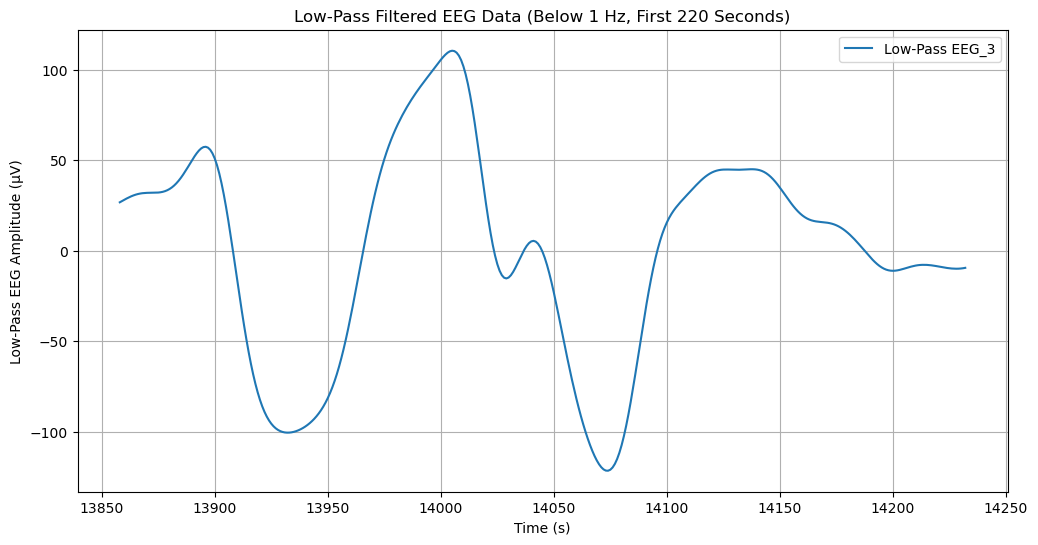

In [168]:
plt.figure(figsize=(12, 6))
plt.plot(range(onset_indices[7], offset_indices[7]), filtered_eeg['EEG_3'][onset_indices[7]: offset_indices[7]], label=f"Low-Pass EEG_3")

plt.xlabel("Time (s)")
plt.ylabel("Low-Pass EEG Amplitude (µV)")
plt.title(f"Low-Pass Filtered EEG Data (Below 1 Hz, First {time_window} Seconds)")
plt.legend()
plt.grid(True)
plt.show()

In [123]:
doi = []

for onset_index in onset_indices:
    offset_index = int(onset_index + fs*1.5)
    doi.append(filtered_eeg['EEG_3'][onset_index:offset_index].to_numpy())

In [141]:
doi[train_labels == 'double_blink']
np.where(train_labels == 'double_blink')[0]

array([ 3,  7, 16, 17, 21, 23, 25, 26, 27, 28, 31, 32])

In [239]:
def find_max_min_pattern(max_peaks, min_peaks):
    # Create a list to store the windows that match the pattern
    pattern_windows = []

    # Iterate through the max peaks and check if the pattern occurs
    for i in range(len(max_peaks) - 2):  # We need at least 5 peaks for a complete pattern
        # Define the candidate window of 5 peaks (max, min, max, min, max)
        candidate_max1 = max_peaks[i]
        candidate_min1 = min_peaks[i] if i < len(min_peaks) else None
        candidate_max2 = max_peaks[i + 1]
        candidate_min2 = min_peaks[i + 1] if i + 1 < len(min_peaks) else None
        candidate_max3 = max_peaks[i + 2]

        # print((candidate_max1, candidate_min1, candidate_max2, candidate_min2, candidate_max3))

        # Check if we have a valid pattern: max, min, max, min, max
        if (candidate_min1 is not None and candidate_max1 < candidate_min1 and
            candidate_max2 > candidate_min1 and candidate_min2 is not None and
            candidate_max2 < candidate_min2 and candidate_max3 > candidate_min2):
            # If the pattern matches, store the start and end indices of the window
            pattern_windows += [candidate_max1, candidate_min1, candidate_max2, candidate_min2, candidate_max3]

            return pattern_windows
    return pattern_windows

In [295]:
def supervised_model(filtered_eeg, onset_indices, labels):
    db = []
    for i, onset_idx in enumerate(onset_indices):
        offset_idx = onset_idx + int(1.5 * fs)

        offset_idx = min(offset_idx, len(filtered_eeg) - 1)

        signal = filtered_eeg['EEG_3'].loc[onset_idx: offset_idx]
        peaks, _ = find_peaks(-1*signal, height=40, distance=60)
        max_peaks, _ = find_peaks(signal, height=20, distance=60)
        potential_peaks = signal.index[0] + peaks
        potential_max_peaks = signal.index[0] + max_peaks

        ground_points = find_max_min_pattern(max_peaks, peaks)
        
        

        if len(ground_points) > 1 and signal[potential_max_peaks].std() < 70:
            # std_before = filtered_eeg['EEG_3'].loc[int(ground_points[0] - 5*fs): ground_points[0]].std()
            # std_after = filtered_eeg['EEG_3'].loc[ground_points[-1]: int(ground_points[-1] + 5*fs)].std()
            # if std_before < 20 and std_after < 20:
            db.append((potential_peaks, potential_max_peaks))
            print(signal.std())
            # print(signal[potential_max_peaks].std())
            fig, ax = plt.subplots()    
            filtered_eeg['EEG_3'].loc[onset_idx: offset_idx].plot(kind='line', title=f"{labels[i]}")
            plt.scatter(potential_peaks, signal[potential_peaks], color='r', label="Potential Peaks", marker='x')
            plt.scatter(potential_max_peaks, signal[potential_max_peaks], color='g', label="Potential Peaks", marker='x')
    return db

41.07144008055442
56.91927912784534
40.5139082546307
35.50241116084689
30.0323380293292
34.24982727608305
37.141413636891954
43.21404155826443
38.99462323489037
38.26103882780361
47.70536673754972
45.07880515381433
54.631869648933026


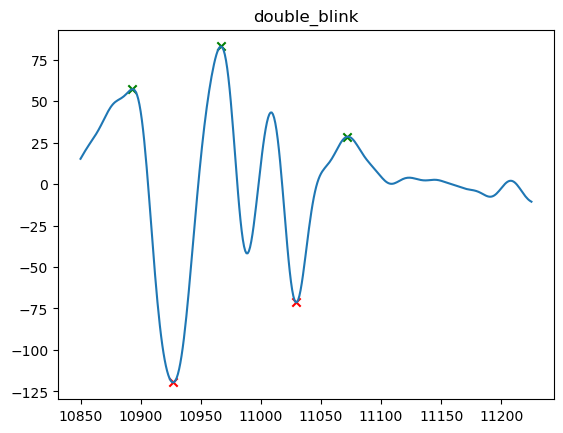

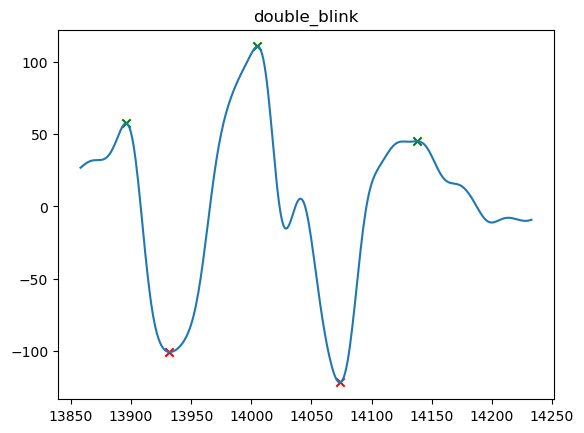

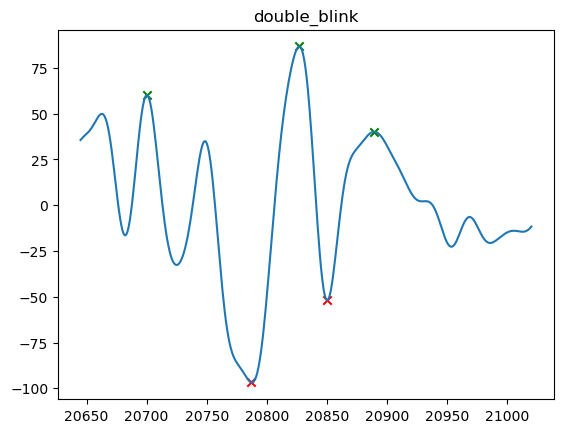

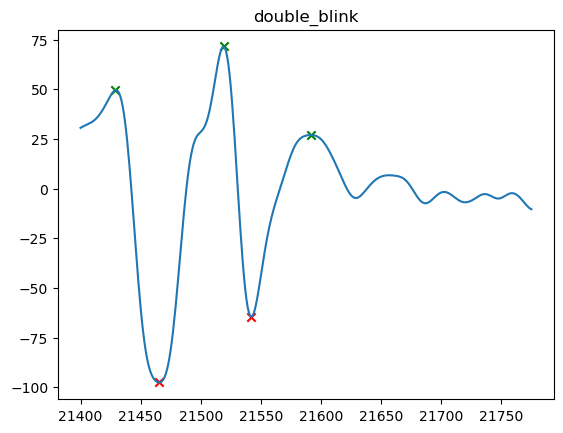

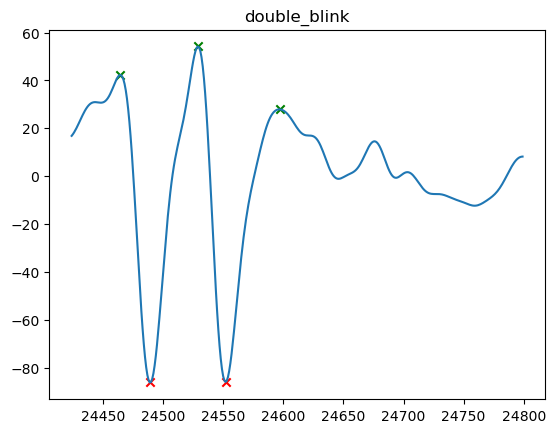

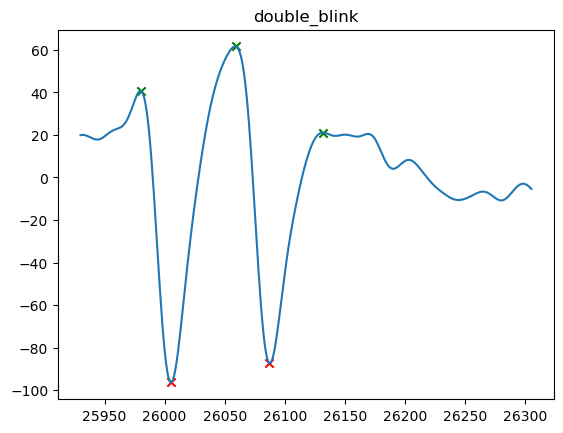

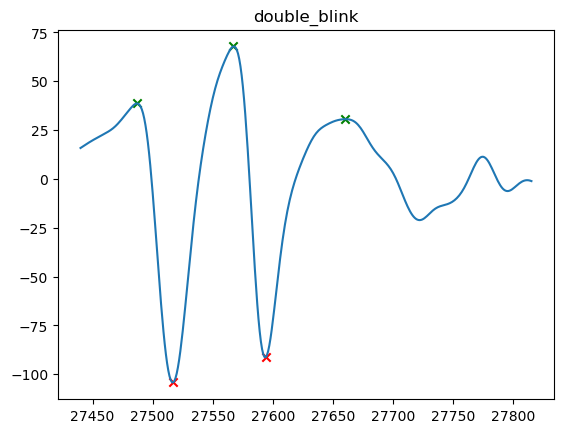

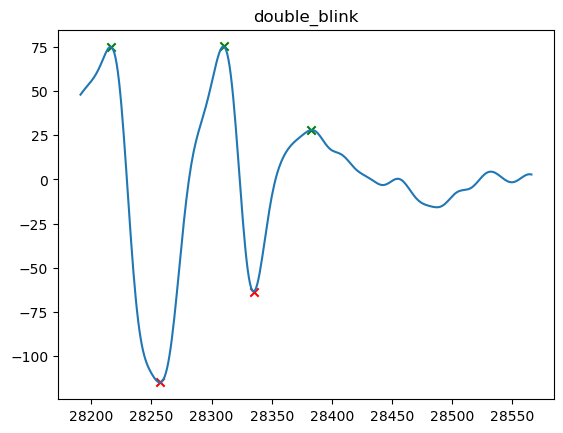

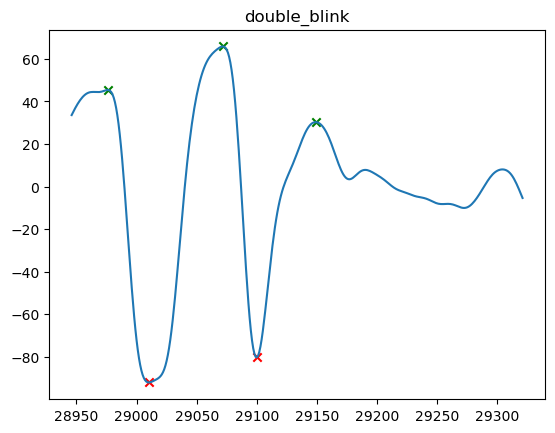

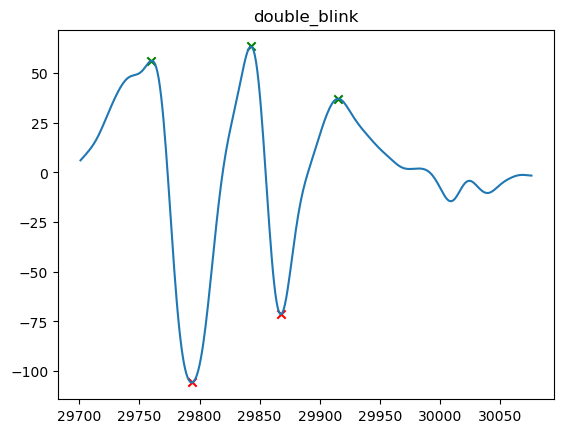

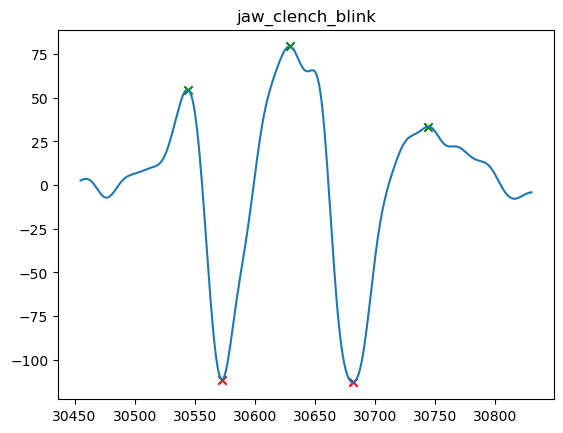

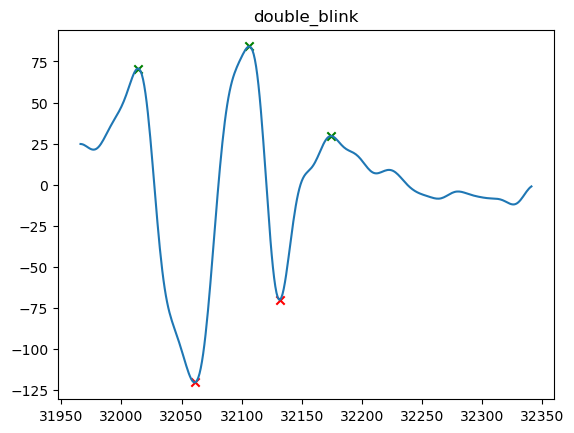

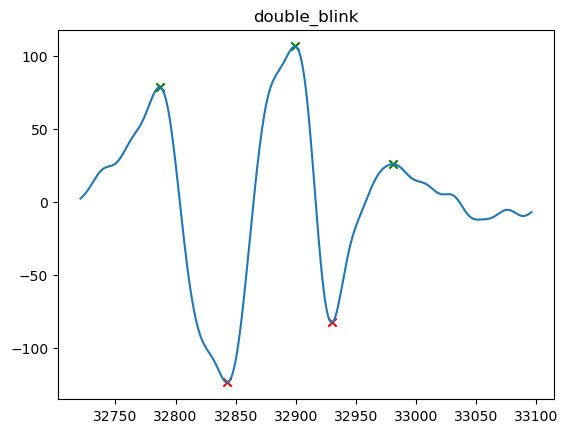

In [296]:
res = supervised_model(filtered_eeg, onset_indices, train_labels)

In [ ]:
def unsupervised_model(filtered_eeg_window):
    if filtered_eeg_window.std() > 10:
        signal = filtered_eeg_window
        peaks, _ = find_peaks(-1*signal, height=40, distance=60)
        max_peaks, _ = find_peaks(signal, height=20, distance=60)
        potential_peaks = signal.index[0] + peaks
        potential_max_peaks = signal.index[0] + max_peaks

        ground_points = find_max_min_pattern(max_peaks, peaks)
        
        

        if len(ground_points) > 1 and signal[potential_max_peaks].std() < 70 and len(peaks) == 2 and (peaks[1] - peaks[0]) < 100:
            # std_before = filtered_eeg['EEG_3'].loc[int(ground_points[0] - 5*fs): ground_points[0]].std()
            # std_after = filtered_eeg['EEG_3'].loc[ground_points[-1]: int(ground_points[-1] + 5*fs)].std()
            # if std_before < 20 and std_after < 20:
            # print(signal[potential_max_peaks].std())
            fig, ax = plt.subplots()    
            filtered_eeg_window.plot(kind='line')
            plt.scatter(potential_peaks, signal[potential_peaks], color='r', label="Potential Peaks", marker='x')
            plt.scatter(potential_max_peaks, signal[potential_max_peaks], color='g', label="Potential Peaks", marker='x')
            return potential_peaks, potential_max_peaks
    return False

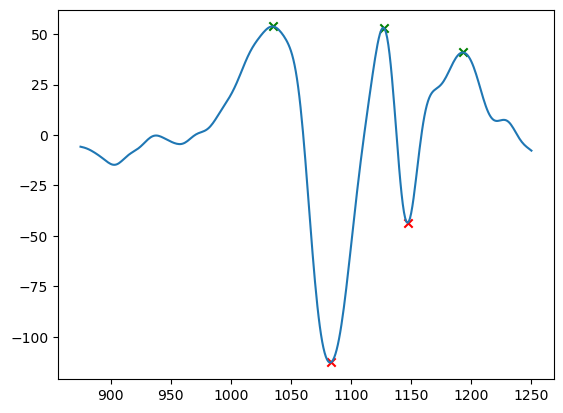

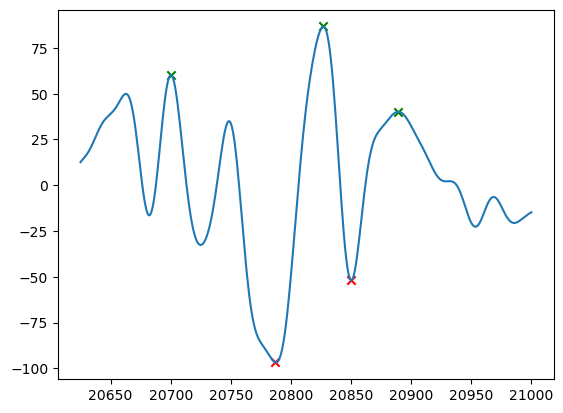

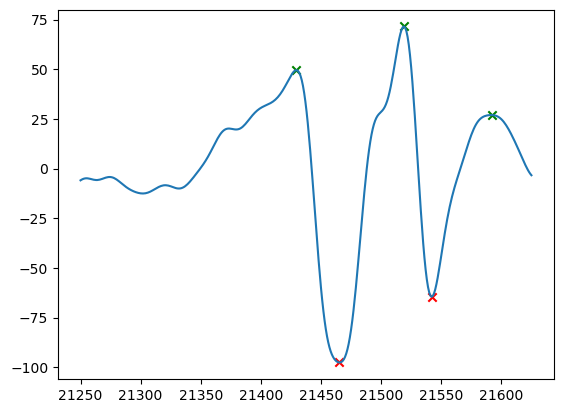

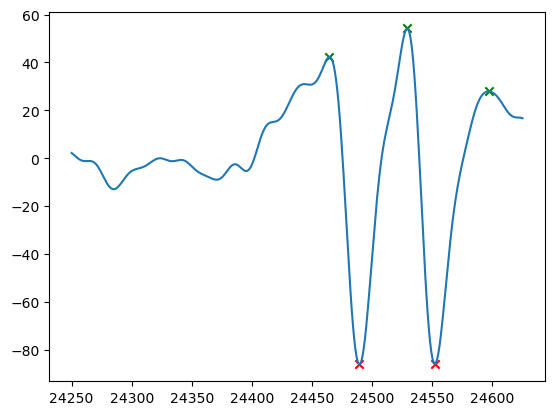

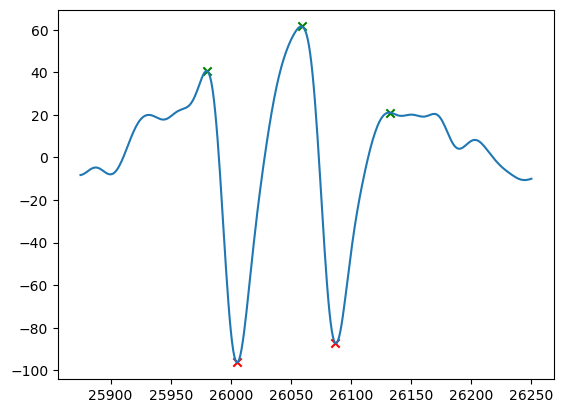

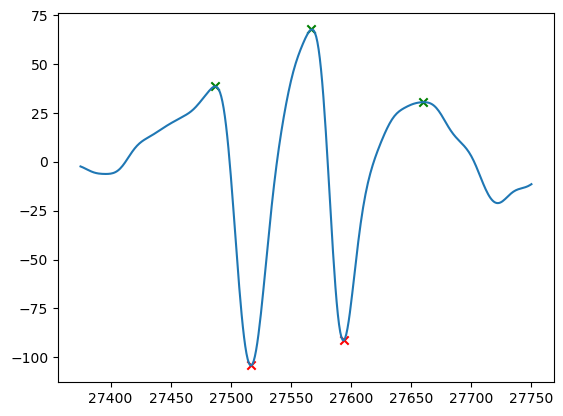

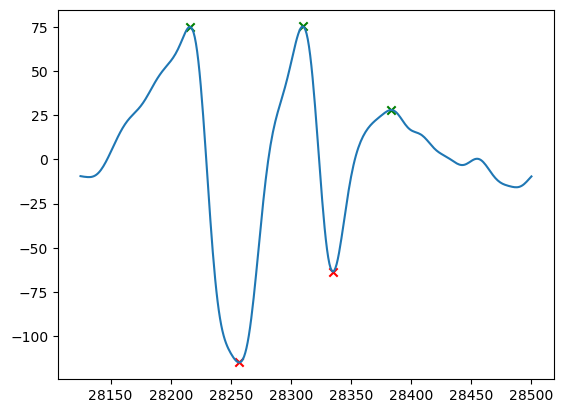

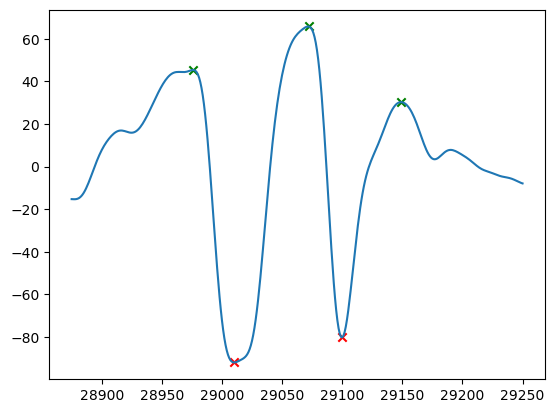

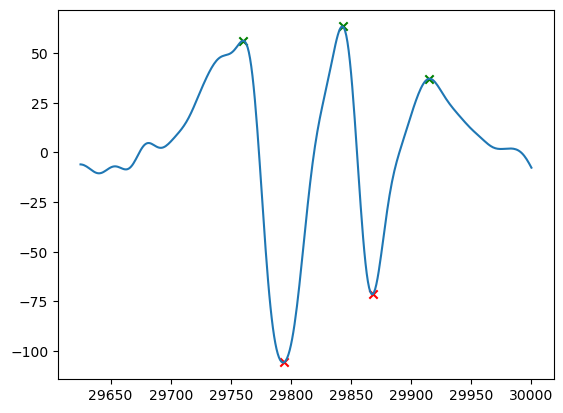

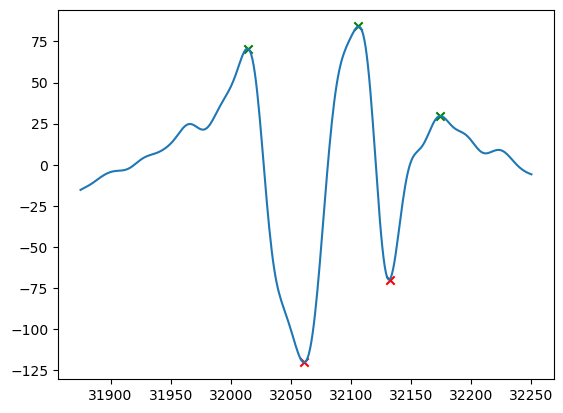

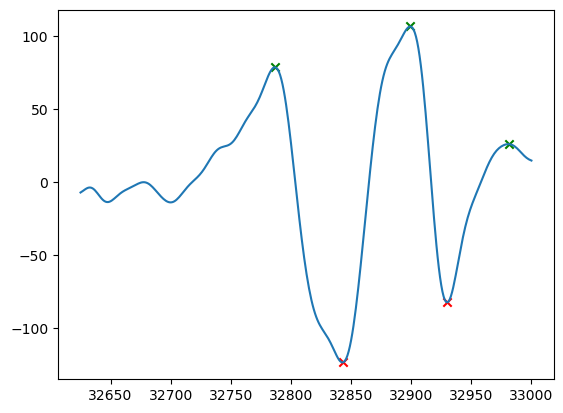

In [292]:
i=0
times_predicted = []
while i < len(filtered_eeg):
    out = unsupervised_model(filtered_eeg['EEG_3'].loc[i: i + int(1.5 * fs)])
    if out:
        i += int(1.5 * fs)
        times_predicted.append(out)
    i += int(0.5 * fs)

In [304]:
true_pos = 0
for i in range(len(times_predicted)):
    for j in res:
        if all(times_predicted[i][0] == j[0]) and all(times_predicted[i][1] == j[1]):
            true_pos += 1
# all(times_predicted[2][1] == res[3][1])

In [306]:
true_pos, len(res), len(times_predicted)

(10, 13, 11)

In [307]:
len(onset_indices[train_labels == 'double_blink'])


12

In [367]:
## finding peaks for simple classifier
def find_max_min_pattern(max_peaks, min_peaks):
    # Create a list to store the windows that match the pattern
    pattern_windows = []

    # Iterate through the max peaks and check if the pattern occurs
    for i in range(len(max_peaks) - 2):  # We need at least 5 peaks for a complete pattern
        # Define the candidate window of 5 peaks (max, min, max, min, max)
        candidate_max1 = max_peaks[i]
        candidate_min1 = min_peaks[i] if i < len(min_peaks) else None
        candidate_max2 = max_peaks[i + 1]
        candidate_min2 = min_peaks[i + 1] if i + 1 < len(min_peaks) else None
        # candidate_max3 = max_peaks[i + 2]

        # print((candidate_max1, candidate_min1, candidate_max2, candidate_min2, candidate_max3))

        # Check if we have a valid pattern: max, min, max, min, max
        if (candidate_min1 is not None and candidate_max1 < candidate_min1 and
            candidate_max2 > candidate_min1 and candidate_min2 is not None and
            candidate_max2 < candidate_min2): #and candidate_max3 > candidate_min2
            # If the pattern matches, store the start and end indices of the window
            pattern_windows += [candidate_max1, candidate_min1, candidate_max2, candidate_min2] #candidate_max3

    return pattern_windows

def filter(window):
    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data, axis=0)
    def lowpass_filter(data, cutoff, fs, order=4):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low')
        return filtfilt(b, a, data, axis=0)
    
    window = bandpass_filter(window, 1, 50, 250)
    window = lowpass_filter(window, 10, 250)
    return window


def model(window, i):
    filtered_eeg_window = filter(window)
    # if filtered_eeg_window.std() > 10:
    signal = filtered_eeg_window
    peaks, _ = find_peaks(-1*signal, height=75, distance=60)
    max_peaks, _ = find_peaks(signal, height=50, distance=40)
    potential_peaks = peaks
    potential_max_peaks =  max_peaks
    ground_points = find_max_min_pattern(max_peaks, peaks)
    print(ground_points)
    if len(ground_points) > 1 and signal[potential_max_peaks].std() < 100 and len(peaks) == 2 and (peaks[1] - peaks[0]) < 250:
        fig, ax = plt.subplots()    
        plt.plot(filtered_eeg_window)
        # plt.scatter(potential_peaks, signal[potential_peaks], color='r', label="Potential Peaks", marker='x')
        plt.scatter(ground_points, signal[ground_points], color='g', label="Potential Peaks", marker='x')
        # fig.savefig(f'blink_graphs/img{i}.png')
        np.save(f'blink_graphs/img{i}.npy', signal)
        return True
        # return potential_peaks, potential_max_peaks

    return False

[105, 138, 181, 201]


Text(0.5, 1.0, 'Low-Pass Filtered EEG Data')

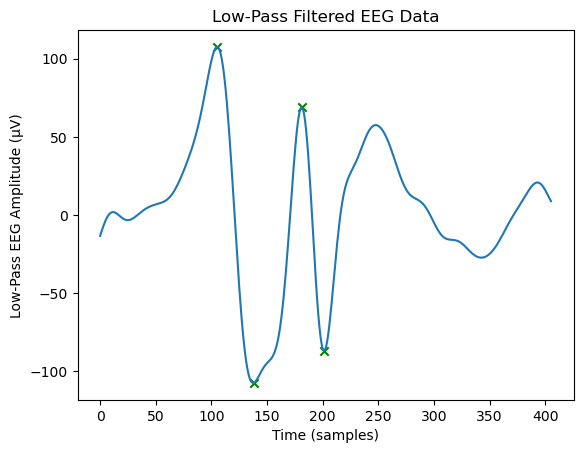

In [380]:
model(np.load("blink_graphs/img249.npy"), 1)
plt.xlabel("Time (samples)")
plt.ylabel("Low-Pass EEG Amplitude (µV)")
plt.title(f"Low-Pass Filtered EEG Data")